# New Steering Prediction Model by training Cascaded CNNs instance segmentation image with image augmentation and limiting angle range 

## Environment Setup

In [2]:
import os
import random
import fnmatch
import datetime
import pickle

import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
import cv2
from imgaug import augmenters as img_aug


tf.__version__: 2.6.0
keras.__version__: 2.6.0


## Data and path preparation

In [3]:
data_dir = ["../ccnn_output_sullychen","../lanenet_output_sullychen"]
sublist = ['/binary_image/','/instance_image/']
#img_path_list = os.listdir(data_dir+"/instance_image")
imgtxt_list,cb_list,ci_list,lb_list,li_list,o_list = [],[],[],[],[],[]
steer_angle_list = []

with open('../SullyChen/data.txt') as f:
    lines = f.readlines()
f.close()
for i in lines:
    steer_angle_list.append(float(i.split()[1][0:5]))
    imgtxt_list.append(i[0:i.find('.jpg')+4])
    cb_list.append(data_dir[0]+sublist[0]+i[0:i.find('.jpg')+4])
    ci_list.append(data_dir[0]+sublist[1]+i[0:i.find('.jpg')+4])
    lb_list.append(data_dir[1]+sublist[0]+i[0:i.find('.jpg')+4])
    li_list.append(data_dir[1]+sublist[1]+i[0:i.find('.jpg')+4])
    o_list.append('../SullyChen/data/'+i[0:i.find('.jpg')+4])

In [8]:
def addp(x):
    return x[:-4]+'_p'+x[-4:]
def addz(x):
    return x[:-4]+'_z'+x[-4:]
def addbr(x):
    return x[:-4]+'_br'+x[-4:]
def addbl(x):
    return x[:-4]+'_bl'+x[-4:]
def addf(x):
    return x[:-4]+'_f'+x[-4:]

#Here means combining two image augmentation technique
#e.g.performing pan and adjust brightness
def addpbr(x):
    return x[:-4]+'_pbr'+x[-4:]
def addzbl(x):
    return x[:-4]+'_zbl'+x[-4:]
    
def addfp(x):
    return x[:-4]+'_fp'+x[-4:]
def addfz(x):
    return x[:-4]+'_fz'+x[-4:]
def addfbr(x):
    return x[:-4]+'_fbr'+x[-4:]
def addfbl(x):
    return x[:-4]+'_fbl'+x[-4:]
def flipangle(x):
    return x*-1

In [20]:
df = pd.DataFrame()
df['Imagepath'] = ci_list
df['Angle'] = steer_angle_list

## Down sampling and tuning of distribution of angles

In [21]:
df_try0 = df[df['Angle']<2][df['Angle']>-1].sample(n=1000)
df_try1 = df[df['Angle']<=-1][df['Angle']>-5].append(df[df['Angle']>=2][df['Angle']<5]).sample(n=5000)
df_try2 = df[df['Angle']<=-5][df['Angle']>-20].append(df[df['Angle']>=5][df['Angle']<20]).sample(n=15000)
df_try3 = df[df['Angle']<=-20][df['Angle']>-60].append(df[df['Angle']>=20][df['Angle']<60])
df_try4 = df[df['Angle']<=-60][df['Angle']>-90].append(df[df['Angle']>=60][df['Angle']<90])
df_temp = pd.concat([df_try0,df_try1,df_try2,df_try3,df_try4]) #29637

df_try3 = pd.concat([df_try3,df_try3,df_try3])
df_try4 = pd.concat([df_try4,df_try4,df_try4,df_try4,df_try4])

/tmp/.tyh002/ipykernel_8652/148699289.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_try0 = df[df['Angle']<2][df['Angle']>-1].sample(n=1000)
/tmp/.tyh002/ipykernel_8652/148699289.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_try1 = df[df['Angle']<=-1][df['Angle']>-5].append(df[df['Angle']>=2][df['Angle']<5]).sample(n=5000)
/tmp/.tyh002/ipykernel_8652/148699289.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_try2 = df[df['Angle']<=-5][df['Angle']>-20].append(df[df['Angle']>=5][df['Angle']<20]).sample(n=15000)
/tmp/.tyh002/ipykernel_8652/148699289.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_try3 = df[df['Angle']<=-20][df['Angle']>-60].append(df[df['Angle']>=20][df['Angle']<60])
/tmp/.tyh002/ipykernel_8652/148699289.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_try4 = df[df['Angle']<=-60]

In [22]:
df_try = pd.concat([df_temp,df_try3,df_try4]).reset_index().drop(columns='index')

In [7]:
#Sample output of path editing
#During training process, when it read the path that contains '_p','_z','_bl','_br', 
#it will perform image augmentation of the path without the adding feature with correspoonding image augmentation function.
df[df['Angle']>=2][df['Angle']<5]['Imagepath'].apply(addp)

/tmp/.tyh002/ipykernel_24606/283746630.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['Angle']>=2][df['Angle']<5]['Imagepath'].apply(addp)


54          ../ccnn_output_sullychen/instance_image/54_p.jpg
55          ../ccnn_output_sullychen/instance_image/55_p.jpg
56          ../ccnn_output_sullychen/instance_image/56_p.jpg
57          ../ccnn_output_sullychen/instance_image/57_p.jpg
58          ../ccnn_output_sullychen/instance_image/58_p.jpg
                                ...                         
63681    ../ccnn_output_sullychen/instance_image/63681_p.jpg
63727    ../ccnn_output_sullychen/instance_image/63727_p.jpg
63728    ../ccnn_output_sullychen/instance_image/63728_p.jpg
63729    ../ccnn_output_sullychen/instance_image/63729_p.jpg
63730    ../ccnn_output_sullychen/instance_image/63730_p.jpg
Name: Imagepath, Length: 10259, dtype: object

In [23]:
df_try.loc[29637:36515,'Imagepath']= df_try.loc[29637:36515,'Imagepath'].apply(addz)
df_try.loc[36516:43394,'Imagepath']= df_try.loc[36516:43394,'Imagepath'].apply(addbl)
df_try.loc[43395:50273,'Imagepath']= df_try.loc[43395:50273,'Imagepath'].apply(addf)
df_try.loc[43395:50273,'Angle']= df_try.loc[43395:50273,'Angle'].apply(flipangle)

df_try.loc[50274:52032,'Imagepath']= df_try.loc[50274:52032,'Imagepath'].apply(addz)
df_try.loc[52033:53790,'Imagepath']= df_try.loc[52033:53790,'Imagepath'].apply(addbl)
df_try.loc[53791:55548,'Imagepath']= df_try.loc[53791:55548,'Imagepath'].apply(addp)
df_try.loc[55549:57306,'Imagepath']= df_try.loc[55549:57306,'Imagepath'].apply(addbr)
df_try.loc[57307:59064,'Imagepath']= df_try.loc[57307:59064,'Imagepath'].apply(addf)
df_try.loc[57307:59064,'Angle']= df_try.loc[57307:59064,'Angle'].apply(flipangle)


In [11]:
df_try.to_csv('../angle_prediction/csv_data/df_ci_aug.csv', index=False)


In [9]:
try_list = list(df_try['Imagepath'])
try_angle = list(df_try['Angle'])

In [24]:
aug_ci_list = list(df_try['Imagepath'])
aug_ci_angle = list(df_try['Angle'])

In [13]:
try_list[34135]

'../ccnn_output_sullychen/instance_image/30935_z.jpg'

In [120]:
print(df_temp.count())
print(df_try3.count())
print(df_try4.count())
print(df_try.count())

Imagepath    29637
Angle        29637
dtype: int64
Imagepath    20637
Angle        20637
dtype: int64
Imagepath    8790
Angle        8790
dtype: int64
Imagepath    59064
Angle        59064
dtype: int64


(array([18.0000, 96.0000, 78.0000, 36.0000, 72.0000, 126.0000, 36.0000,
        132.0000, 96.0000, 90.0000, 198.0000, 126.0000, 96.0000, 102.0000,
        108.0000, 186.0000, 444.0000, 210.0000, 246.0000, 216.0000,
        138.0000, 192.0000, 156.0000, 474.0000, 144.0000, 222.0000,
        336.0000, 384.0000, 498.0000, 318.0000, 136.0000, 188.0000,
        240.0000, 96.0000, 120.0000, 156.0000, 128.0000, 124.0000,
        184.0000, 112.0000, 212.0000, 244.0000, 268.0000, 116.0000,
        128.0000, 148.0000, 124.0000, 144.0000, 208.0000, 164.0000,
        240.0000, 176.0000, 224.0000, 340.0000, 200.0000, 388.0000,
        596.0000, 392.0000, 196.0000, 284.0000, 336.0000, 220.0000,
        204.0000, 300.0000, 440.0000, 388.0000, 360.0000, 652.0000,
        532.0000, 604.0000, 167.0000, 183.0000, 222.0000, 375.0000,
        308.0000, 345.0000, 290.0000, 354.0000, 386.0000, 453.0000,
        566.0000, 442.0000, 687.0000, 759.0000, 974.0000, 798.0000,
        363.0000, 330.0000, 472.0000, 

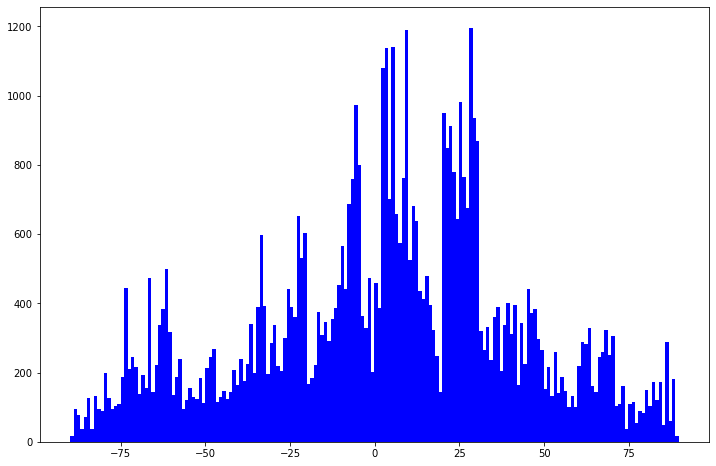

In [119]:
#New angle distribution
fig, axes = plt.subplots(1,1, figsize=(12,8))
axes.cla()
num_of_bins = 180
samples_per_bin = 100
hist, bins = np.histogram(df_try['Angle'], num_of_bins)

axes.hist(df_try['Angle'], bins=num_of_bins, width=1, color='blue')

## Training of model

### train-test-valid data split

### Function to preprocessing data
#### including:
#### 1. Read data
#### 2. Preprocess data with removing height, converting to YUV space, resize and normalizing
#### 3. Batch Data generation
#### 4. Image augmentation functions

In [25]:
random.seed(34)
X_train_ci_aug, X_test_ci_aug, y_train_ci_aug, y_test_ci_aug = train_test_split(aug_ci_list, aug_ci_angle, test_size=0.15,random_state=34)
X_train_ci_aug, X_valid_ci_aug, y_train_ci_aug, y_valid_ci_aug = train_test_split(X_train_ci_aug, y_train_ci_aug, test_size=3/17, random_state=34)
ci_aug_testdf = pd.DataFrame()
ci_aug_testdf['Imagepath'] = X_test_ci_aug
ci_aug_testdf['Angle'] = y_test_ci_aug
ci_aug_testdf.to_csv('../angle_prediction/csv_data/testdf_ci_aug.csv', index=False)


In [13]:
def my_imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [14]:
# image augmentation:

def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.25))  # zoom from 100% (no zoom) to 125%
    image = zoom.augment_image(image)
    return image

def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

def blur(image):
    kernel_size = random.randint(1, 5) 
    image = cv2.blur(image,(kernel_size, kernel_size))
   
    return image

def flip(image):
    # randomly flip horizon
    image = cv2.flip(image,1)

    return image


In [2]:
def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]  # remove top 0.5 of the image, as it is not relavant for lane following
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV) # suggested by Nvidia model
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing
    return image


In [16]:
def build_model():
    model = Sequential()

    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='elu')) 

    model.add(Flatten())
    model.add(Dropout(0.2)) 
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: steering angle (0 is straight, <0 turn left, >0 turn right)
    model.add(Dense(1)) 

    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [43]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 20, 64)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [15]:
def image_gen_original(image_paths, steering_angles, batch_size):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
             
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))
            
            

In [17]:
def image_data_generator_0(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            steering_angle = steering_angles[random_index]
            if is_training:
                if '_z' in image_path:
                    image = my_imread(image_path[:-6]+image_path[-4:])
                    image = zoom(image)
                elif '_p' in image_path:
                    image = my_imread(image_path[:-6]+image_path[-4:])
                    image = pan(image)
                elif '_bl' in image_path:
                    image = my_imread(image_path[:-7]+image_path[-4:])
                    image = blur(image)
                elif '_br' in image_path:
                    image = my_imread(image_path[:-7]+image_path[-4:])
                    image = adjust_brightness(image)
                elif '_f' in image_path:
                    image = my_imread(image_path[:-6]+image_path[-4:])
                    image = flip(image)
                else:
                    image = my_imread(image_paths[random_index])
            else:
                image = my_imread(image_paths[random_index])
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))
            
            

In [30]:
model = build_model()
model_dir = '../angle_prediction/aug/'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('../angle_prediction/aug/lane_keeping_angle_ci.h5'), verbose=1, save_best_only=True)

history = model.fit_generator(image_data_generator_0(X_train_ci_aug, y_train_ci_aug, batch_size=1024,is_training =True),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data = image_data_generator_0( X_valid_ci_aug, y_valid_ci_aug, batch_size=128,is_training =True),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])

model.save(os.path.join(model_dir,'lane_navigation_final_aug_ci.h5'))

history_path = os.path.join(model_dir,'history_aug_ci.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)


Epoch 1/10
300/300 [==============================] - 3421s 11s/step - loss: 751.2524 - val_loss: 257.9659

Epoch 00001: val_loss improved from inf to 257.96585, saving model to ../angle_prediction/aug/lane_keeping_angle_ci.h5
Epoch 2/10
300/300 [==============================] - 3244s 11s/step - loss: 179.8792 - val_loss: 116.9700

Epoch 00002: val_loss improved from 257.96585 to 116.97003, saving model to ../angle_prediction/aug/lane_keeping_angle_ci.h5
Epoch 3/10
300/300 [==============================] - 3258s 11s/step - loss: 101.3368 - val_loss: 76.0559

Epoch 00003: val_loss improved from 116.97003 to 76.05589, saving model to ../angle_prediction/aug/lane_keeping_angle_ci.h5
Epoch 4/10
300/300 [==============================] - 3292s 11s/step - loss: 71.5405 - val_loss: 56.2775

Epoch 00004: val_loss improved from 76.05589 to 56.27754, saving model to ../angle_prediction/aug/lane_keeping_angle_ci.h5
Epoch 5/10
300/300 [==============================] - 3292s 11s/step - loss: 56.